<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/gd_uap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import random
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
import tensorflow as tf
import moviepy.editor as mvp
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.utils import make_grid
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
from moviepy.editor import VideoClip

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Utils

In [3]:
def normalize_imgs(imgs):
    mean = imgs.mean(dim=(2,3),keepdims=True)
    std = imgs.std(dim=(2,3),keepdims=True)
    return tfms.functional.normalize(imgs, mean, std)


def minmax_scale(x, axis=None):
    mx = x.max(axis=axis, keepdims=True)
    mn = x.min(axis=axis, keepdims=True)
    return (x - mn) / (mx - mn)


def imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

## Data

In [4]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
normalize = tfms.Normalize(MEAN, STD)
denormalize = tfms.Normalize(-MEAN / STD, 1 / STD)

transform = tfms.Compose([
    tfms.Resize(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
])
dataset = dset.CIFAR10("data", train=False, transform=transform, download=True)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16)

Files already downloaded and verified


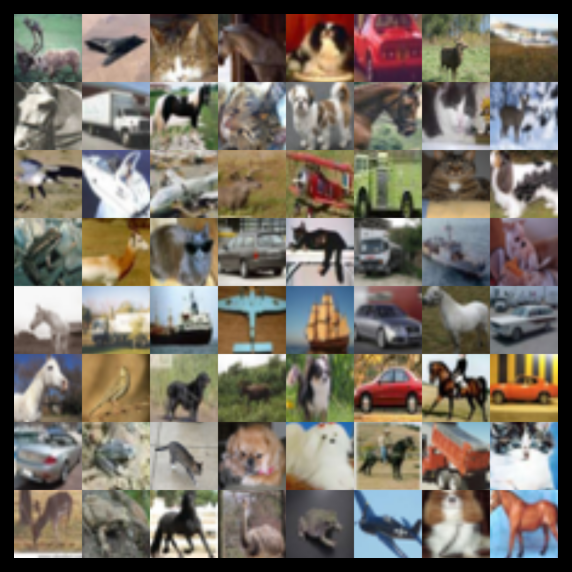

In [5]:
images, _ = next(iter(dataloader))

imshow(make_grid(images[:64], nrow=8, padding=0).permute(1,2,0).numpy())

## Training

In [6]:
def get_conv_layers(model):
    return [module for module in model.modules() if type(module) == nn.Conv2d]

def l2_layer_loss(model, delta, layers):
    activations = []
    handles = []

    def activation_recorder_hook(mod, inp, output):
        activations.append(output)

    for conv_layer in layers:
        handle = conv_layer.register_forward_hook(activation_recorder_hook)
        handles.append(handle)

    model(delta)

    for handle in handles:
        handle.remove()

    loss = 0.0
    for act in activations:
        loss += torch.log(act.square().sum() / 2)
    return -loss

def get_rate_of_saturation(delta, xi):
    return (delta.abs() == xi_max).type(torch.float32).mean().item()

def get_fooling_rate(model, delta, dataloader):
    flipped = 0.0
    total = 0.0

    with torch.no_grad():
        for images, labels in progress_bar(dataloader):
            images = images.to(device)
            adv_images = torch.add(delta, images).clamp(0, 1)

            outputs = model(normalize(images))
            adv_outputs = model(normalize(adv_images))
            _, predicted = torch.max(outputs.data, 1)
            _, adv_predicted = torch.max(adv_outputs.data, 1)

            flipped += (predicted != adv_predicted).sum().item()
            total += images.size(0)

    return flipped / total

In [7]:
model = models.vgg16(pretrained=True).eval().to(device)
layers = get_conv_layers(model)

In [8]:
def plot_metrics(metrics):
    fig = plt.figure(figsize=(10,4))

    for k, v in metrics.items():
        plt.plot(v, '-', alpha=0.8, label=k)

    plt.legend()
    plt.title('Metrics')
    plt.tight_layout()
    plt.show()


def plot_uap(img):
    img = make_grid(normalize_imgs(img)).permute(1,2,0).numpy()
    imshow(minmax_scale(img))

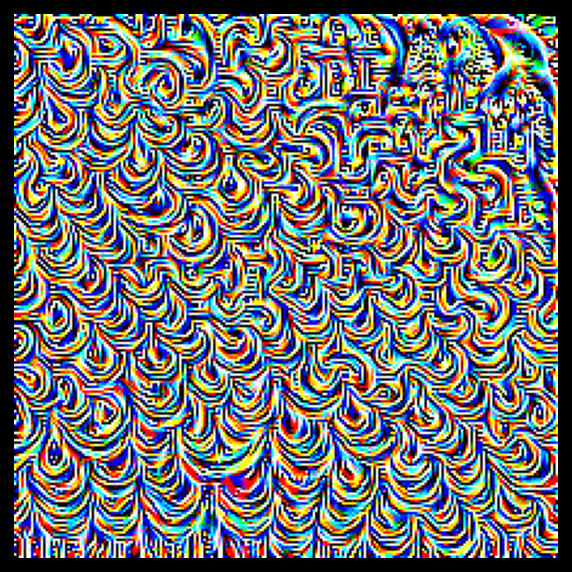

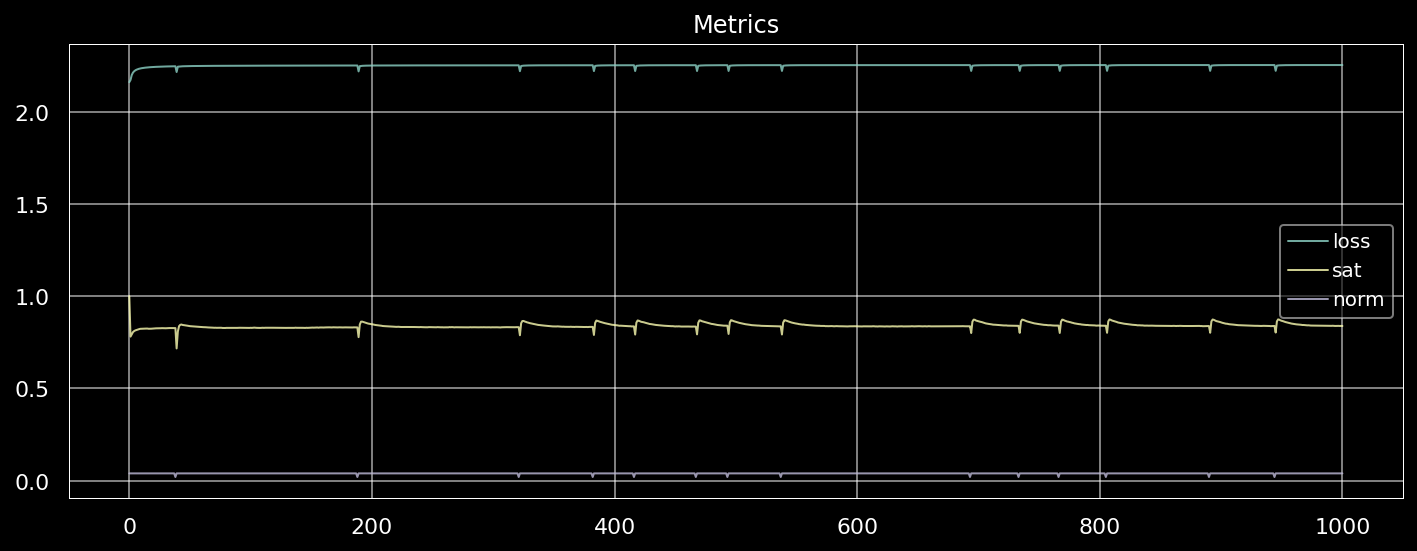

[1000/1001] log10(-loss): 2.2529 norm: 0.0392 sat: 0.8383

In [9]:
#@title Training Loop {vertical-output: true}

size = 224
xi_min, xi_max = -10/255, 10/255
delta = ((xi_min - xi_max) * torch.rand((1, 3, size, size), device=device) + xi_max).requires_grad_(True)

epochs = 1001
optimizer = torch.optim.Adam([delta], lr=0.1)

sat = 0
sat_prev = 0
sat_threshold = 0.00001
sat_min = 0.5

metrics = {"loss": [], "sat": [], "norm": []}

for epoch in range(epochs):

    optimizer.zero_grad()
    loss = l2_layer_loss(model, delta, layers)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        delta.clamp_(xi_min, xi_max)

    sat_prev = sat
    sat = get_rate_of_saturation(delta, xi_max)
    sat_change = abs(sat - sat_prev)

    if sat_change < sat_threshold and sat > sat_min:
        with torch.no_grad():
            delta /= 2

    metrics["loss"].append(np.log10(-loss.item()))
    metrics["sat"].append(sat)
    metrics["norm"].append(delta.norm(p=np.inf))

    if epoch % 200 == 0:
        clear_output(True)
        plot_uap(delta.detach().cpu())
        plot_metrics(metrics)

    print("\r[{}/{}] log10(-loss): {:.4f} norm: {:.4f} sat: {:.4f}".format(
        epoch, epochs, metrics["loss"][-1], metrics["norm"][-1], sat), 
        end="")


In [10]:
get_fooling_rate(model, delta, dataloader)

0.9999